# QF605 | Fixed Income Securities
## Project

#### Members
1. Jung Hyung-yun
2. Lim Jeng
3. Nguyen Ngo Duy Quang
4. Shao Jiayu
5. Sun Qiaozhen
6. Tan Hui Shan
7. Tan Wei Hao

In [3]:
import numpy as np
import pandas as pd
from enum import Enum

from IPython.display import display
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.optimize import brentq, fsolve, least_squares

## Part 2

#### Displaced Diffusion
$$
\begin{align*}
V^{rec}_{n,N}(0) = P_{n+1,N}(0) \cdot \left[ K \Phi(-d_2) - S_{n,N}(0) \Phi (-d_1) \right] \\\\
V^{pay}_{n,N}(0) = P_{n+1,N}(0) \cdot \left[ S_{n,N}(0) \Phi(d_1) - K \Phi (d_2) \right] \\\\
d_1 = \frac{\ln{\frac{S_{n,N}(0)}{K} + \frac{1}{2} \sigma^2_{n_N} T}}{\sigma_{n,N} \sqrt{T}} \quad , d_2 = d_1 - \sigma_{n,N}\sqrt{T} \\\\
V_{n,N}(0) = P_{n_1,N}(0) Black \left(\frac{S_{n,N}(0)}{\beta}, K + \frac{1 - \beta}{\beta} S_{n,N} (0), \sigma \beta, T \right)
\end{align*}
$$

In [6]:
class PayoffType(str, Enum):
    Call = "call"
    Put = "put"

def black76(F, K, sigma, pvbp, T, payoffType):
    d1 = (np.log(F/K) + 1/2 * sigma * sigma * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if payoffType == PayoffType.Call:
        return pvbp * (F * norm.cdf(d1) - K * norm.cdf(d2))
    elif payoffType == PayoffType.Put:
        return pvbp * (K * norm.cdf(-d2) - F * norm.cdf(-d1))
    else:
        raise Exception(f"payoffType not supported: {payoffType}")

def displacedDiffusion(F, K, sigma, pvbp, beta, T, payoffType):
    _F = F / beta
    _K = K + (1 - beta) / beta * F
    _sigma = sigma * beta
    return black76(_F, _K, _sigma, pvbp, T, payoffType)
    
def ddVol(F, K, sigma, pvbp, beta, T):
    if F <= K:
        p = displacedDiffusion(F, K, sigma, pvbp, beta, T, PayoffType.Call)
        v = brentq(lambda x: p - black76(F, K, x, pvbp, T, PayoffType.Call), 1e-12, 10)
    else:
        p = displacedDiffusion(F, K, sigma, pvbp, beta, T, PayoffType.Put)
        v = brentq(lambda x: p - black76(F, K, x, pvbp, T, PayoffType.Put), 1e-12, 10)
    return v

def ddCalib(x, F, Ks, Vs, pvbp, T):
    err = 0
    sigma = Vs[5]
    for i, v in enumerate(Vs):
        err += (v - ddVol(F, Ks[i], sigma, pvbp, x, T)) ** 2
    return err

def sabr(F, K, T, alpha, beta, rho, nu):
    X = K
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom
    return sabrsigma

def sabrVol(F, K, pvbp, T, alpha, beta, rho, nu):
    sigma = sabr(F, K, T, alpha, beta, rho, nu)
    if F <= K:
        p = black76(F, K, sigma, pvbp, T, PayoffType.Call)
        v = brentq(lambda x: p - black76(F, K, x, pvbp, T, PayoffType.Call), 1e-12, 10)
    else:
        p = black76(F, K, sigma, pvbp, T, PayoffType.Put)
        v = brentq(lambda x: p - black76(F, K, x, pvbp, T, PayoffType.Put), 1e-12, 10)
    return v

def sabrCalib(x, b, F, Ks, Vs, T):
    err = 0.0
    for i, v in enumerate(Vs):
        err += (v - sabr(F, Ks[i], T, x[0], b, x[1], x[2]))**2
    return err

In [7]:
libor = pd.read_excel("Data_1_Output.xlsx", sheet_name = "liborDiscFactors")
ois = pd.read_excel("Data_1_Output.xlsx", sheet_name = "oisDiscFactors")

fsr = pd.read_excel("Data_1_Output.xlsx", sheet_name = "fwdSwapRates")
fsr = fsr.pivot(index = "Start", columns = "Tenor", values = "liborForwardSwapRate")
fsr.columns = fsr.columns.str.extract(r"(\d+)", expand = False).astype(int)
fsr.index = fsr.index.str.extract(r"(\d+)", expand = False).astype(int)

strikes = np.array([-.02, -.015, -.01, -.005, -.0025, 0, .0025, .005, .01, .015, .02])
idx = np.where(strikes == 0)[0][0]

swaption = pd.read_excel("IR Data.xlsx", sheet_name = "Swaption")
swaption.columns = swaption.iloc[1]
swaption = swaption[2:].rename_axis(None, axis=1)
swaption["Expiry"] = swaption["Expiry"].str.extract(r"(\d+)", expand = False).astype(int)
swaption["Tenor"] = swaption["Tenor"].str.extract(r"(\d+)", expand = False).astype(int)
swaption = swaption.set_index(["Expiry", "Tenor"]) * 0.01
swaption.columns = strikes

display("OIS" , ois, "LIBOR", libor, "Forward Swap Rate", fsr, "Swaption Vols", swaption)

'OIS'

,T0,TN,DiscountFactor
0,0,0.0,1.000000
1,0,0.5,0.998752
2,0,1.0,0.997009
3,0,1.5,0.995270
4,0,2.0,0.993531
...,...,...,...
56,0,28.0,0.857703
57,0,28.5,0.855126
58,0,29.0,0.852548
59,0,29.5,0.849986


'LIBOR'

,T0,TN,DiscountFactor
0,0,0.0,1.000000
1,0,0.5,0.987654
2,0,1.0,0.972577
3,0,1.5,0.957378
4,0,2.0,0.942179
...,...,...,...
56,0,28.0,0.260568
57,0,28.5,0.251340
58,0,29.0,0.242112
59,0,29.5,0.232884


'Forward Swap Rate'

Tenor,10,1,2,3,5
Start,,,,,
10,0.053458,0.042190,0.043116,0.044097,0.046249
1,0.038428,0.032007,0.033259,0.034011,0.035255
5,0.043634,0.039274,0.040075,0.040072,0.041093


'Swaption Vols'

-0.0200  -0.0150  -0.0100  -0.0050  -0.0025  0.0000  0.0025  \
Expiry Tenor                                                                
1      1       0.9157   0.6203   0.4413  0.31224  0.26182   0.225  0.2096   
       2       0.8327   0.6124   0.4657  0.35807  0.31712  0.2872  0.2712   
       3       0.7392   0.5687   0.4477  0.35745  0.32317  0.2978  0.2829   
       5       0.5519   0.4464   0.3651  0.30242  0.27851  0.2607  0.2498   
       10      0.4118   0.3504  0.30207  0.26619  0.25351  0.2447  0.2398   
5      1        0.678   0.4909    0.384  0.31485   0.2906  0.2726  0.2604   
       2       0.5788   0.4641  0.39033  0.33653  0.31531  0.2983  0.2856   
       3       0.5343   0.4444   0.3818  0.33437  0.31536  0.2998  0.2876   
       5       0.4199  0.36524  0.32326  0.29005  0.27677   0.266  0.2573   
       10     0.34417  0.30948  0.28148  0.25954  0.25136  0.2451  0.2399   
10     1       0.5516   0.4432  0.37368  0.32259   0.3021  0.2854  0.2731   
       2       0.5117    0.429  0.37078  0.32622    0.308  0.2928  0.2809   
       3       0.4822   0.4143    0.364  0.32439  0.30796   0.294  0.2827   
       5       0.4055  0.35891  0.32181  0.29144  0.27857  0.2674   0.258   
       10     0.33601  0.30509  0.27978  0.25926  0.25086  0.2437  0.2376   

              0.0050  0.0100   0.0150   0.0200  
Expiry Tenor                                    
1      1       0.214  0.2434  0.27488  0.30297  
       2      0.2684  0.2851  0.31025  0.33523  
       3       0.278  0.2877  0.30725  0.32833  
       5      0.2456  0.2512  0.26536  0.28165  
       10     0.2382  0.2425  0.25204  0.26355  
5      1      0.2532  0.2494   0.2532   0.2598  
       2      0.2765  0.2671   0.2654   0.2676  
       3      0.2782  0.2667    0.262   0.2615  
       5      0.2502  0.2406   0.2357    0.234  
       10     0.2356  0.2291   0.2249   0.2225  
10     1      0.2645  0.2561   0.2552   0.2578  
       2       0.272  0.2612   0.2572   0.2571  
       3      0.2738  0.2618   0.2558   0.2537  
       5      0.2502  0.2387   0.2317    0.228  
       10     0.2324  0.2244    0.219   0.2156

In [8]:
exp = swaption.index.get_level_values("Expiry").unique()
ten = swaption.index.get_level_values("Tenor").unique()
df1 = pd.DataFrame(index = exp, columns = ten)

beta = df1.copy()
sigma = df1.copy()
alpha = df1.copy()
rho = df1.copy()
nu = df1.copy()

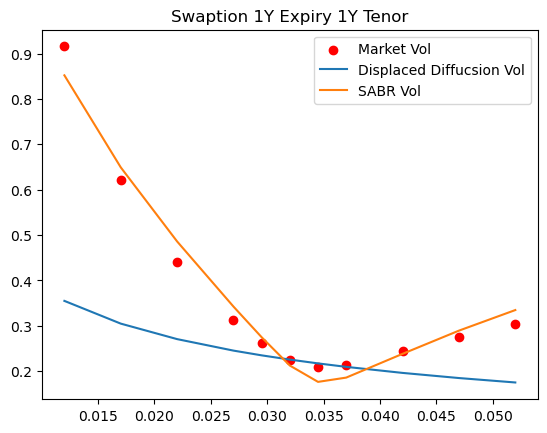

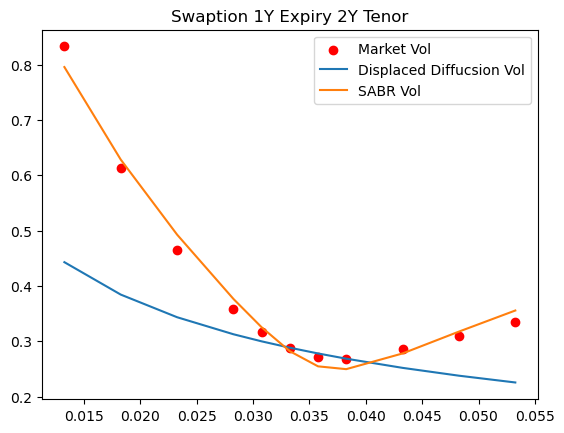

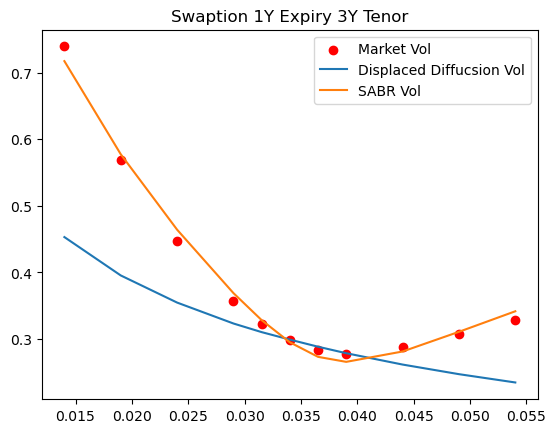

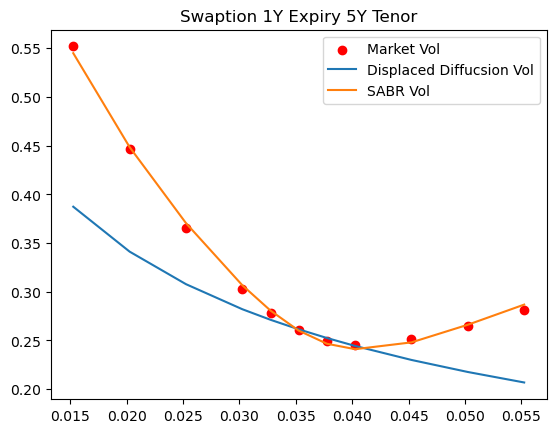

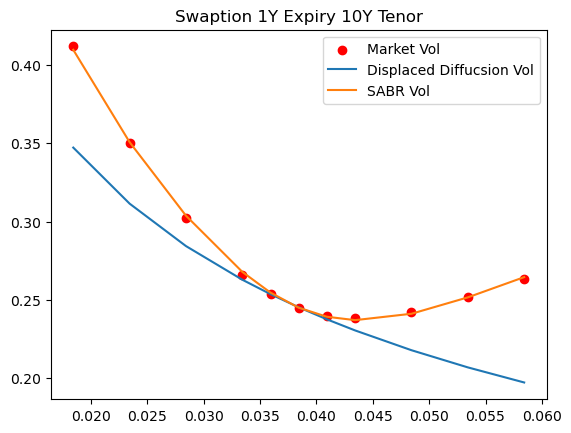

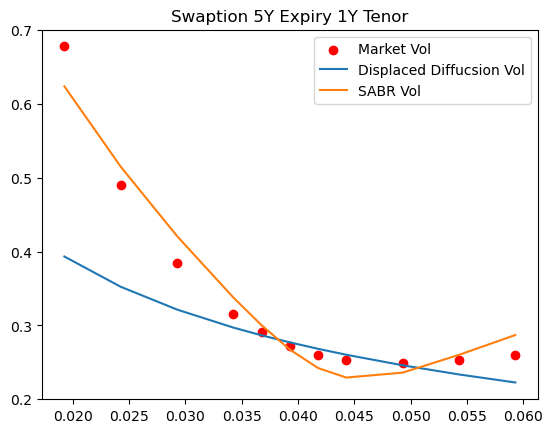

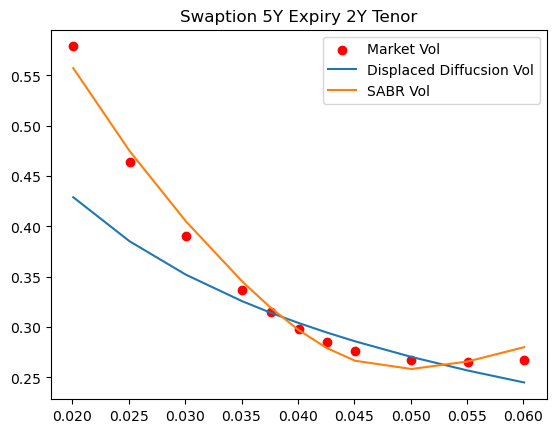

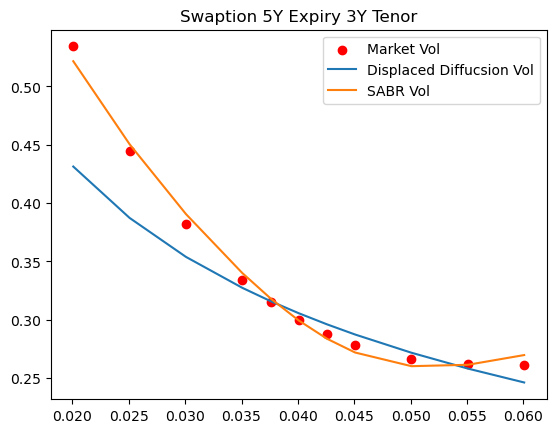

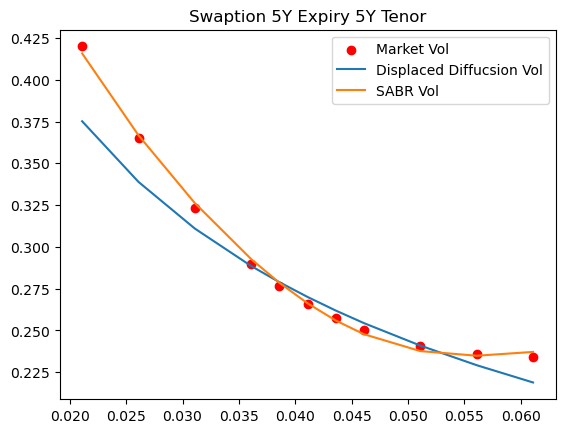

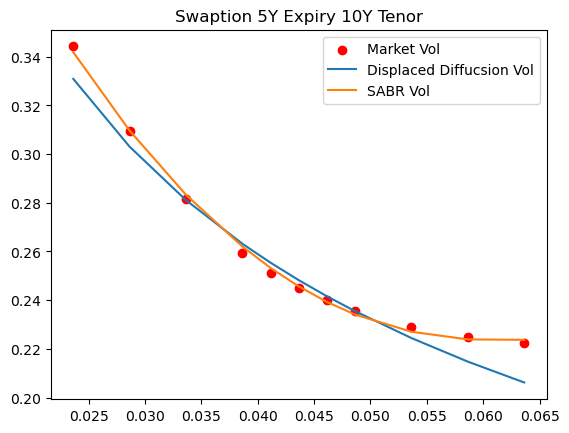

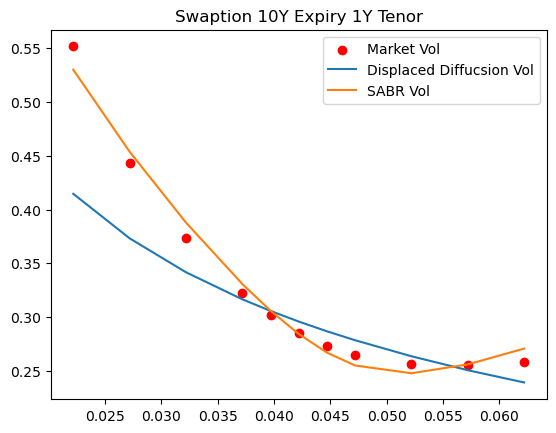

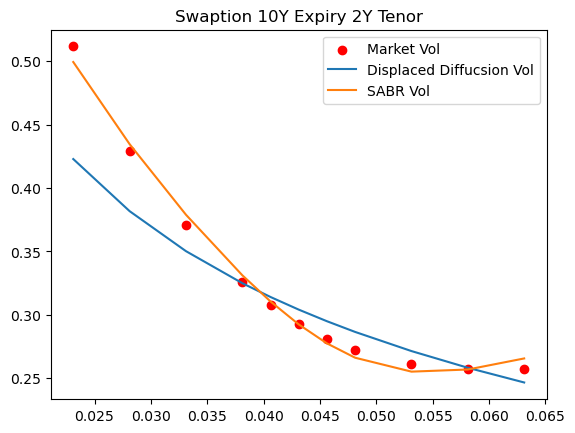

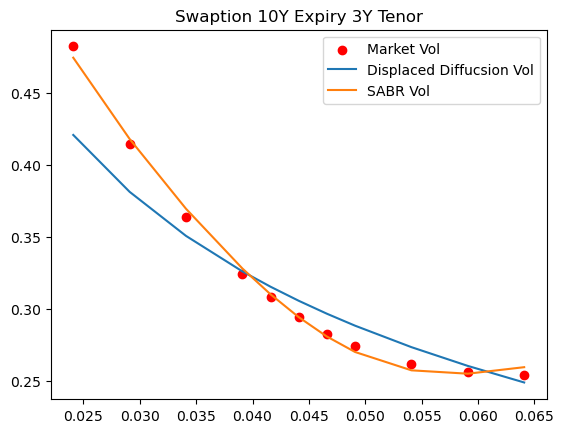

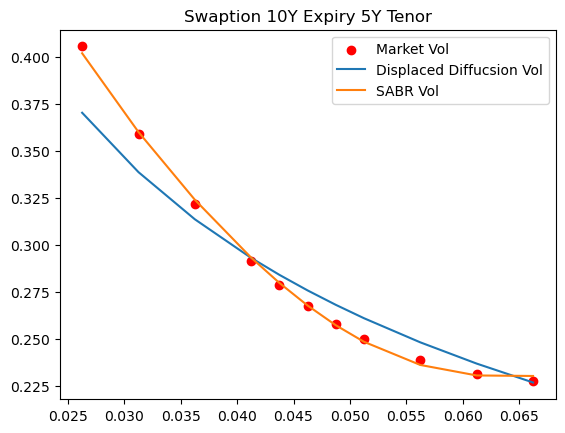

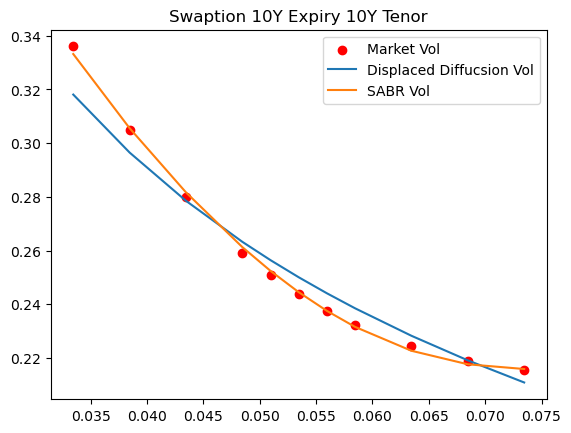

'SIGMA'

Tenor,1,2,3,5,10
Expiry,,,,,
1,0.225,0.2872,0.2978,0.2607,0.2447
5,0.2726,0.2983,0.2998,0.266,0.2451
10,0.2854,0.2928,0.294,0.2674,0.2437


'BETA'

Tenor,1,2,3,5,10
Expiry,,,,,
1,1.6145e-10,9.1629e-08,1.3434e-12,8.1524e-11,2.4891e-05
5,8.9744e-07,1.5707e-07,1.5790e-05,7.3192e-06,5.7789e-02
10,5.1734e-07,8.9856e-09,1.6196e-06,6.1283e-05,6.4572e-04


'ALPHA'

Tenor,1,2,3,5,10
Expiry,,,,,
1,0.13907,0.184647,0.196849,0.178062,0.171021
5,0.166602,0.199521,0.210357,0.191001,0.177155
10,0.177853,0.195584,0.208323,0.20174,0.180614


'RHO'

Tenor,1,2,3,5,10
Expiry,,,,,
1,-0.633221,-0.525118,-0.482842,-0.41445,-0.263658
5,-0.585585,-0.546983,-0.549818,-0.510956,-0.438235
10,-0.546856,-0.545385,-0.553748,-0.563249,-0.509587


'NU'

Tenor,1,2,3,5,10
Expiry,,,,,
1,2.049472,1.677432,1.438152,1.064819,0.77933
5,1.340311,1.061989,0.936747,0.671784,0.496321
10,1.008429,0.926444,0.871802,0.720186,0.578903


In [9]:
b = 0.9
for ex in exp:
    for t in ten:
        F = fsr.loc[ex, t]
        Ks = F + strikes
        Vs = swaption.loc[(ex, t),:].values
        _ois = ois["DiscountFactor"].loc[(ois["TN"] <= ex + t) & (ois["TN"] > ex)]
        pvbp = _ois.sum() * 0.5
                
        sigma.loc[ex, t] = Vs[idx]
        
        beta_res = least_squares(
            lambda x: ddCalib(x, F, Ks, Vs, pvbp, ex),
            [0.7],
            bounds = ([0,1])
        )
        beta.loc[ex, t] = f"{beta_res.x[0]:.4e}"
        
        sabr_res = least_squares(
            lambda x: sabrCalib(x, b, F, Ks, Vs, ex),
            [0.15, -0.6, 0.5],
            bounds = ([0, -1, 0], [np.inf, 1, np.inf])
        )
        alpha.loc[ex, t] = sabr_res.x[0]
        rho.loc[ex, t] = sabr_res.x[1]
        nu.loc[ex, t] = sabr_res.x[2]
        
        ddVs = [ddVol(F, K, sigma.loc[ex, t], pvbp, beta_res.x[0], ex) for K in Ks]
        sabrVs = [sabrVol(F, K, pvbp, ex, sabr_res.x[0], b, sabr_res.x[1], sabr_res.x[2]) for K in Ks]

        plt.scatter(Ks, Vs, label = "Market Vol", c = "r")
        plt.plot(Ks, ddVs, label = "Displaced Diffucsion Vol")
        plt.plot(Ks, sabrVs, label = "SABR Vol")
        plt.legend()
        plt.title(f"Swaption {ex}Y Expiry {t}Y Tenor")
        plt.show()

display("SIGMA", sigma, "BETA", beta, "ALPHA", alpha, "RHO", rho, "NU", nu)

In [10]:
df2 = pd.DataFrame(index = list(range(1, 11)))
df2.index.name = "Expiry"

sigma_intpl = df2.merge(sigma, how = "left", left_index = True, right_index = True)
sigma_intpl.columns.name = "Tenor"
sigma_intpl.loc[:,:] = sigma_intpl.loc[:,:].astype(float).interpolate(method = 'linear')

beta_intpl = df2.merge(beta, how = "left", left_index = True, right_index = True)
beta_intpl.columns.name = "Tenor"
beta_intpl.loc[:,:] = beta_intpl.loc[:,:].astype(float).interpolate(method = 'linear')

alpha_intpl = df2.merge(alpha, how = "left", left_index = True, right_index = True)
alpha_intpl.columns.name = "Tenor"
alpha_intpl.loc[:,:] = alpha_intpl.loc[:,:].astype(float).interpolate(method = 'linear')

rho_intpl = df2.merge(rho, how = "left", left_index = True, right_index = True)
rho_intpl.columns.name = "Tenor"
rho_intpl.loc[:,:] = rho_intpl.loc[:,:].astype(float).interpolate(method = 'linear')

nu_intpl = df2.merge(nu, how = "left", left_index = True, right_index = True)
nu_intpl.columns.name = "Tenor"
nu_intpl.loc[:,:] = nu_intpl.loc[:,:].astype(float).interpolate(method = 'linear')

display("SIGMA", sigma_intpl, "BETA", beta_intpl, "ALPHA", alpha_intpl, "RHO", rho_intpl, "NU", nu_intpl)

C:\Users\Qiaozhen\AppData\Local\Temp\ipykernel_7448\3007456979.py:4: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  sigma_intpl = df2.merge(sigma, how = "left", left_index = True, right_index = True)
C:\Users\Qiaozhen\AppData\Local\Temp\ipykernel_7448\3007456979.py:8: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  beta_intpl = df2.merge(beta, how = "left", left_index = True, right_index = True)
C:\Users\Qiaozhen\AppData\Local\Temp\ipykernel_7448\3007456979.py:12: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a futu

'SIGMA'

Tenor,1,2,3,5,10
Expiry,,,,,
1,0.225,0.2872,0.2978,0.2607,0.2447
2,0.2369,0.289975,0.2983,0.262025,0.2448
3,0.2488,0.29275,0.2988,0.26335,0.2449
4,0.2607,0.295525,0.2993,0.264675,0.245
5,0.2726,0.2983,0.2998,0.266,0.2451
6,0.27516,0.2972,0.29864,0.26628,0.24482
7,0.27772,0.2961,0.29748,0.26656,0.24454
8,0.28028,0.295,0.29632,0.26684,0.24426
9,0.28284,0.2939,0.29516,0.26712,0.24398


'BETA'

Tenor,1,2,3,5,10
Expiry,,,,,
1,0.0,0.0,0.0,0.0,0.000025
2,0.0,0.0,0.000004,0.000002,0.014466
3,0.0,0.0,0.000008,0.000004,0.028907
4,0.000001,0.0,0.000012,0.000005,0.043348
5,0.000001,0.0,0.000016,0.000007,0.057789
6,0.000001,0.0,0.000013,0.000018,0.04636
7,0.000001,0.0,0.00001,0.000029,0.034932
8,0.000001,0.0,0.000007,0.00004,0.023503
9,0.000001,0.0,0.000004,0.00005,0.012074


'ALPHA'

Tenor,1,2,3,5,10
Expiry,,,,,
1,0.13907,0.184647,0.196849,0.178062,0.171021
2,0.145953,0.188365,0.200226,0.181297,0.172555
3,0.152836,0.192084,0.203603,0.184532,0.174088
4,0.159719,0.195803,0.20698,0.187767,0.175622
5,0.166602,0.199521,0.210357,0.191001,0.177155
6,0.168853,0.198734,0.20995,0.193149,0.177847
7,0.171103,0.197947,0.209544,0.195297,0.178539
8,0.173353,0.197159,0.209137,0.197445,0.17923
9,0.175603,0.196372,0.20873,0.199593,0.179922


'RHO'

Tenor,1,2,3,5,10
Expiry,,,,,
1,-0.633221,-0.525118,-0.482842,-0.41445,-0.263658
2,-0.621312,-0.530585,-0.499586,-0.438576,-0.307302
3,-0.609403,-0.536051,-0.51633,-0.462703,-0.350947
4,-0.597494,-0.541517,-0.533074,-0.486829,-0.394591
5,-0.585585,-0.546983,-0.549818,-0.510956,-0.438235
6,-0.577839,-0.546664,-0.550604,-0.521415,-0.452506
7,-0.570093,-0.546344,-0.55139,-0.531873,-0.466776
8,-0.562348,-0.546025,-0.552176,-0.542332,-0.481047
9,-0.554602,-0.545705,-0.552962,-0.552791,-0.495317


'NU'

Tenor,1,2,3,5,10
Expiry,,,,,
1,2.049472,1.677432,1.438152,1.064819,0.77933
2,1.872182,1.523572,1.312801,0.96656,0.708578
3,1.694891,1.369711,1.187449,0.868301,0.637826
4,1.517601,1.21585,1.062098,0.770043,0.567073
5,1.340311,1.061989,0.936747,0.671784,0.496321
6,1.273934,1.03488,0.923758,0.681465,0.512838
7,1.207558,1.007771,0.910769,0.691145,0.529354
8,1.141181,0.980662,0.89778,0.700826,0.54587
9,1.074805,0.953553,0.884791,0.710506,0.562387


In [11]:
def calcS(ex, t):
    _libor = libor["DiscountFactor"].loc[(ois["TN"] <= ex + t) & (ois["TN"] > ex)]
    _ois = ois["DiscountFactor"].loc[(ois["TN"] <= ex + t) & (ois["TN"] > ex)]

    fix = _ois.iloc[1:].sum()
    flt = 0
    for i in range(1, len(_libor)):
        flt += _ois.iloc[i] * _libor.iloc[i - 1] / _libor.iloc[i]

    return (flt - fix) / (0.5 * fix)

def calcPrice(ex, t, Ks, payoffType):
    _sigma = sigma_intpl.loc[ex, t]
    _beta = beta_intpl.loc[ex, t]
    _alpha = alpha_intpl.loc[ex, t]
    _rho = rho_intpl.loc[ex, t]
    _nu = nu_intpl.loc[ex, t]
    _pvbp = ois["DiscountFactor"].loc[(ois["TN"] <= ex + t) & (ois["TN"] > ex)].sum() * 0.5
    _s = calcS(ex, t)

    _dd = [displacedDiffusion(_s, K, _sigma, _pvbp, _beta, t, payoffType) for K in Ks]
    _sabr = [black76(
        _s,
        K,
        sabr(_s, K, t, _alpha, b, _rho, _nu),
        _pvbp,
        t,
        payoffType
    ) for K in Ks]
    prices = pd.DataFrame({"DD": _dd, "SABR": _sabr}, index = Ks)
    prices.index.name = "Strikes"
    prices.columns.name = "Model"
    return prices

#### Payer 2y 10y
> Strikes
> 1%, 2%, 3%, 4%, 5%, 6%, 7%, 8%

In [13]:
pay_t = 10
pay_ex = 2
pay_Ks = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
calcPrice(pay_ex, pay_t, pay_Ks, PayoffType.Call)

Model,DD,SABR
Strikes,,
0.01,0.316383,0.334971
0.02,0.239909,0.267090
0.03,0.173646,0.197794
0.04,0.119241,0.139116
0.05,0.077246,0.106950
0.06,0.046971,0.095910
0.07,0.026693,0.092837
0.08,0.014125,0.092520


#### Receiver 8y 10y
> Strikes
> 1%, 2%, 3%, 4%, 5%, 6%, 7%, 8%

In [15]:
rec_t = 10
rec_ex = 2
rec_Ks = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
calcPrice(rec_ex, rec_t, rec_Ks, PayoffType.Put)

Model,DD,SABR
Strikes,,
0.01,0.026119,0.044707
0.02,0.046638,0.073820
0.03,0.077369,0.101516
0.04,0.119956,0.139831
0.05,0.174955,0.204658
0.06,0.241673,0.290612
0.07,0.318388,0.384533
0.08,0.402813,0.481208


In [16]:
# with pd.ExcelWriter("Part_2.xlsx") as writer:
#     # Write each DataFrame to a separate sheet
#     sigma.to_excel(writer, sheet_name='sigma', index=False)
#     beta.to_excel(writer, sheet_name='beta', index=False)
#     alpha.to_excel(writer, sheet_name='alpha', index=False)
#     rho.to_excel(writer, sheet_name='rho', index=False)
#     nu.to_excel(writer, sheet_name='nu', index=False)